<a href="https://colab.research.google.com/github/rohinish404/learning_pytorch/blob/master/pytorch_classification_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sklearn

In [2]:
from sklearn.datasets import make_moons  
n_samples=1000
X,y = make_moons(n_samples,
                   noise = 0.03,
                   random_state=42)

In [3]:
len(X)

1000

In [4]:
X[:10]

array([[-0.00933187,  0.39098105],
       [ 0.95457387, -0.47375583],
       [ 0.9185256 , -0.42519648],
       [ 0.41276802, -0.37638459],
       [-0.84532016,  0.52879908],
       [ 0.57954249, -0.35297867],
       [ 0.29488426, -0.20923768],
       [-0.01448804,  0.4358961 ],
       [ 1.62651037, -0.28120742],
       [ 0.67159767,  0.78642227]])

In [5]:
y[:10]

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0])

In [6]:
import pandas as pd
moons = pd.DataFrame({"X1" : X[:,0],
                        "X2" : X[:,1],
                        "label":y})

In [7]:
moons.head()

,X1,X2,label
0,-0.009332,0.390981,1
1,0.954574,-0.473756,1
2,0.918526,-0.425196,1
3,0.412768,-0.376385,1
4,-0.845320,0.528799,0


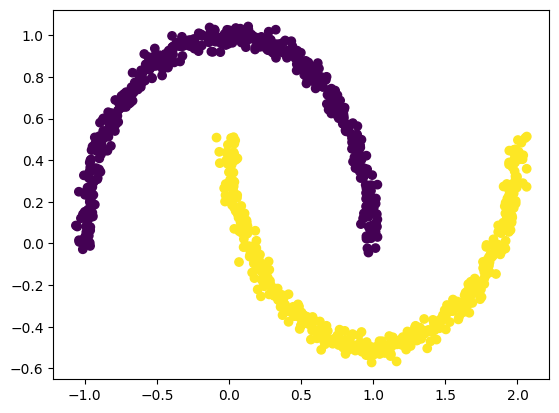

In [8]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y)

In [9]:
import torch
torch.__version__

'1.13.1+cu116'

In [10]:
type(X)

numpy.ndarray

In [11]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [12]:
type(X)

torch.Tensor

In [13]:

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state=42)

In [14]:

import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [42]:
class ModelMoons(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=2, out_features=28),
            nn.ReLU(),
            nn.Linear(in_features=28, out_features=28),
            nn.ReLU(),
            nn.Linear(in_features=28, out_features=1),
        )

    def forward(self, x):
        return self.layer_stack(x)

model_1 = ModelMoons().to(device)
model_1

ModelMoons(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=28, bias=True)
    (1): ReLU()
    (2): Linear(in_features=28, out_features=28, bias=True)
    (3): ReLU()
    (4): Linear(in_features=28, out_features=1, bias=True)
  )
)

In [55]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1) 

In [56]:
!pip -q install torchmetrics # colab doesn't come with torchmetrics
from torchmetrics import Accuracy
acc_fn = Accuracy(task="multiclass", num_classes=2).to(device) # send accuracy function to device
acc_fn

MulticlassAccuracy()

In [57]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)


for epoch in range(epochs):
    model_1.train()

    y_logits = model_1(X_train.to(device))
    y_pred = torch.round(torch.sigmoid(y_logits)).squeeze()

    loss = loss_fn(y_logits, y_train.unsqueeze(1))
    acc = acc_fn(y_pred, y_train.int())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = acc_fn(test_pred, y_test.int())

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}")


Epoch: 0 | Loss: 0.17821, Accuracy: 0.92% | Test loss: 0.17630, Test acc: 0.93
Epoch: 100 | Loss: 0.13704, Accuracy: 0.94% | Test loss: 0.13535, Test acc: 0.94
Epoch: 200 | Loss: 0.09208, Accuracy: 0.97% | Test loss: 0.08941, Test acc: 0.98
Epoch: 300 | Loss: 0.05585, Accuracy: 0.99% | Test loss: 0.05283, Test acc: 1.00
Epoch: 400 | Loss: 0.03451, Accuracy: 1.00% | Test loss: 0.03177, Test acc: 1.00
Epoch: 500 | Loss: 0.02300, Accuracy: 1.00% | Test loss: 0.02070, Test acc: 1.00
Epoch: 600 | Loss: 0.01647, Accuracy: 1.00% | Test loss: 0.01459, Test acc: 1.00
Epoch: 700 | Loss: 0.01248, Accuracy: 1.00% | Test loss: 0.01091, Test acc: 1.00
Epoch: 800 | Loss: 0.00986, Accuracy: 1.00% | Test loss: 0.00857, Test acc: 1.00
Epoch: 900 | Loss: 0.00804, Accuracy: 1.00% | Test loss: 0.00696, Test acc: 1.00
